In [22]:
import os
from pathlib import Path
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Obtener la ruta del directorio processed_constellations
processed_dir = Path('processed_constellations')

# Crear lista con todas las imágenes que terminan en _circles.png
circles_images = sorted([
    str(processed_dir / file) 
    for file in os.listdir(processed_dir) 
    if file.endswith('_circles.png')
])

print(f"Total de imágenes encontradas: {len(circles_images)}")
print("\nPrimeras 10 imágenes:")
for img in circles_images[:10]:
    print(f"  - {img}")

Total de imágenes encontradas: 88

Primeras 10 imágenes:
  - processed_constellations/image0_circles.png
  - processed_constellations/image10_circles.png
  - processed_constellations/image11_circles.png
  - processed_constellations/image12_circles.png
  - processed_constellations/image13_circles.png
  - processed_constellations/image14_circles.png
  - processed_constellations/image15_circles.png
  - processed_constellations/image16_circles.png
  - processed_constellations/image17_circles.png
  - processed_constellations/image18_circles.png


In [23]:
path = "./cons_image.jpg"

# Leer la imagen
image = cv2.imread(path)
if image is None:
    raise FileNotFoundError(f"No se pudo cargar la imagen en la ruta: {path}")

In [24]:
def ransac_constellation(image_space, pattern_image):
    # Convertir a escala de grises
    gray_space = cv2.cvtColor(image_space, cv2.COLOR_BGR2GRAY)
    gray_pattern = cv2.cvtColor(pattern_image, cv2.COLOR_BGR2GRAY)

    # Detectar bordes usando Canny
    edges_space = cv2.Canny(gray_space, 50, 150)
    edges_pattern = cv2.Canny(gray_pattern, 50, 150)

    # Encontrar contornos
    contours_space, _ = cv2.findContours(edges_space, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_pattern, _ = cv2.findContours(edges_pattern, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Extraer puntos de los contornos
    points_space = np.vstack([cnt.squeeze() for cnt in contours_space if cnt.shape[0] >= 5])
    points_pattern = np.vstack([cnt.squeeze() for cnt in contours_pattern if cnt.shape[0] >= 5])

    if len(points_space) < 3 or len(points_pattern) < 3:
        raise ValueError("No hay suficientes puntos para aplicar RANSAC.")

    # Usar RANSAC para encontrar la mejor transformación
    model_robust, inliers = cv2.estimateAffinePartial2D(points_pattern, points_space, method=cv2.RANSAC)

    if model_robust is None:
        raise ValueError("No se pudo encontrar una transformación robusta.")

    # Aplicar la transformación a la imagen del patrón
    h, w = image_space.shape[:2]
    transformed_pattern = cv2.warpAffine(pattern_image, model_robust, (w, h))

    return transformed_pattern, model_robust

In [25]:
import pandas as pd

df = pd.read_csv('constellations_with_names.csv')

# Función para extraer el nombre del archivo sin extensión
def get_image_basename(full_path):
    return Path(full_path).stem

# Función para encontrar el path de la imagen procesada
def find_processed_image(basename):
    circles_path = processed_dir / f"{basename}_circles.png"
    if circles_path.exists():
        return str(circles_path)
    return None

# Función para calcular centroides de una imagen
def circles_centroides(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9, 9), 2)
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=30,
                               param1=50, param2=30, minRadius=5, maxRadius=30)
    
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        centroids = [(x, y) for (x, y, r) in circles]
        return centroids
    else:
        return []

# Añadir columnas al DataFrame
df['image_basename'] = df['full_path'].apply(get_image_basename)
df['processed_image_path'] = df['image_basename'].apply(find_processed_image)

# Calcular centroides para cada imagen procesada
def get_centroids(processed_path):
    if processed_path and Path(processed_path).exists():
        img = cv2.imread(processed_path)
        if img is not None:
            return circles_centroides(img)
    return []

df['centroids'] = df['processed_image_path'].apply(get_centroids)
df['num_stars'] = df['centroids'].apply(len)

display(df.head())
print(f"\nTotal de constelaciones: {len(df)}")
print(f"Constelaciones con imágenes procesadas: {df['processed_image_path'].notna().sum()}")
print(f"Constelaciones con centroides detectados: {(df['num_stars'] > 0).sum()}")

,full_path,constellation_name,image_basename,processed_image_path,centroids,num_stars
0,/home/stargix/.cache/kagglehub/datasets/thepra...,Sagitta – Arrow,image70,processed_constellations/image70_circles.png,"[(855, 1030), (134, 232), (315, 421), (767, 75...",5
1,/home/stargix/.cache/kagglehub/datasets/thepra...,Pisces – Fishes,image65,processed_constellations/image65_circles.png,"[(465, 993), (951, 1048), (992, 1167), (164, 9...",15
2,/home/stargix/.cache/kagglehub/datasets/thepra...,Lacerta – Lizard,image44,processed_constellations/image44_circles.png,"[(693, 981), (105, 196), (338, 393), (430, 556...",8
3,/home/stargix/.cache/kagglehub/datasets/thepra...,Chamaeleon – Chameleon,image21,processed_constellations/image21_circles.png,"[(1030, 471), (58, 703), (397, 488), (422, 707...",6
4,/home/stargix/.cache/kagglehub/datasets/thepra...,Vulpecula – Little Fox,image87,processed_constellations/image87_circles.png,"[(783, 652), (40, 470), (286, 506), (448, 835)...",5



Total de constelaciones: 90
Constelaciones con imágenes procesadas: 88
Constelaciones con centroides detectados: 88


In [26]:
import sys
from pathlib import Path

# Agregar el directorio raíz al path
root_dir = Path().absolute().parent
sys.path.insert(0, str(root_dir))

# Agregar también el directorio python directamente al path
python_dir = root_dir / 'python'
sys.path.insert(0, str(python_dir))

# Ahora puedes importar directamente desde tools
from tools import extract_boxes_from_image

print("Importación exitosa!")


Importación exitosa!


Cargando imagen AVIF: /home/stargix/Desktop/hackathons/NASA/NASA-AI-i-Oli/tests/cositas.jpg
Imagen convertida guardada en: /home/stargix/Desktop/hackathons/NASA/NASA-AI-i-Oli/tests/cositas_temp.jpg
Boxes detectadas: 1


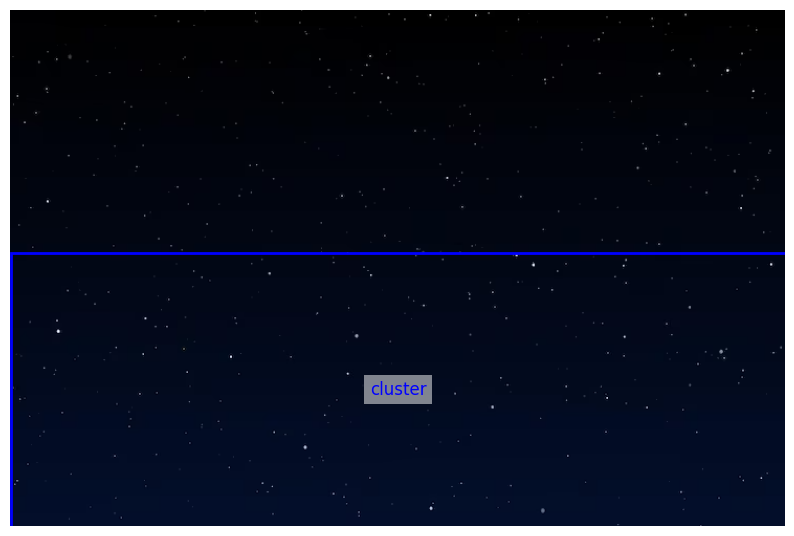

In [ ]:
# El archivo cositas.jpg es en realidad un archivo AVIF, no JPG
# Necesitamos convertirlo primero o usar PIL que sí soporta AVIF

from PIL import Image
import numpy as np
from pathlib import Path

current_dir = Path().absolute()
path = str(current_dir / "cositas.jpg")

print(f"Cargando imagen AVIF: {path}")

# Cargar con PIL (soporta AVIF)
pil_image = Image.open(path)
# Convertir a RGB si es necesario
if pil_image.mode != 'RGB':
    pil_image = pil_image.convert('RGB')

# Convertir PIL a numpy array (formato OpenCV)
image_np = np.array(pil_image)
# PIL usa RGB, OpenCV usa BGR
image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

# Guardar temporalmente como JPG real para extract_boxes_from_image
temp_jpg_path = str(current_dir / "cositas_temp.jpg")
cv2.imwrite(temp_jpg_path, image_bgr)

print(f"Imagen convertida guardada en: {temp_jpg_path}")

# Ahora procesar con extract_boxes_from_image
image_boxes = extract_boxes_from_image(temp_jpg_path, )

print(f"Boxes detectadas: {len(image_boxes)}")

# Visualizar
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(image_np)  # Usar la versión RGB para matplotlib

for box in image_boxes:
    cx, cy = box.center
    w, h = box.width, box.height
    rect = plt.Rectangle((cx - w/2, cy - h/2), w, h, linewidth=2, edgecolor=box.color, facecolor='none')
    ax.add_patch(rect)
    ax.text(cx, cy, box.obj_type, color=box.color, fontsize=12, ha='center', va='center', 
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

plt.axis('off')
plt.show()


In [28]:
for img in circles_images:
    print(f"Procesando imagen: {img}")
    image_space = cv2.imread(img)




# Supongamos que tenemos dos listas de puntos correspondientes
src_points = np.array([[x1, y1], [x2, y2], [x3, y3], ...], dtype=np.float32)
dst_points = np.array([[x1p, y1p], [x2p, y2p], [x3p, y3p], ...], dtype=np.float32)

# Estimar transformación afín con RANSAC
M, inliers = cv2.estimateAffinePartial2D(src_points, dst_points, method=cv2.RANSAC, ransacReprojThreshold=3)

print("Matriz de transformación:")
print(M)

# Filtrar solo inliers (estrellas que encajan en el patrón)
inlier_src = src_points[inliers.ravel() == 1]
inlier_dst = dst_points[inliers.ravel() == 1]


Procesando imagen: processed_constellations/image0_circles.png
Procesando imagen: processed_constellations/image10_circles.png
Procesando imagen: processed_constellations/image11_circles.png
Procesando imagen: processed_constellations/image12_circles.png
Procesando imagen: processed_constellations/image13_circles.png
Procesando imagen: processed_constellations/image14_circles.png
Procesando imagen: processed_constellations/image15_circles.png
Procesando imagen: processed_constellations/image16_circles.png
Procesando imagen: processed_constellations/image17_circles.png
Procesando imagen: processed_constellations/image18_circles.png
Procesando imagen: processed_constellations/image19_circles.png
Procesando imagen: processed_constellations/image1_circles.png
Procesando imagen: processed_constellations/image20_circles.png
Procesando imagen: processed_constellations/image21_circles.png
Procesando imagen: processed_constellations/image22_circles.png
Procesando imagen: processed_constellation

NameError: name 'x1' is not defined